# Comprehensive Tutorial on Recurrent Neural Networks (RNNs) and LSTMs in PyTorch

This tutorial is designed to last about **90 minutes** and will take you on a journey through recurrent neural networks and LSTMs using PyTorch. 

We will cover:

- A brief theoretical background on RNNs and the challenges (e.g., vanishing gradients).
- Implementation of a simple RNN for sequence prediction using a synthetic sine wave dataset.
- An introduction to LSTMs and how they overcome some limitations of standard RNNs.
- Implementation of an LSTM model, including discussions on stacked and bidirectional variants.

In [1]:
# Import necessary libraries
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Theoretical Background

### Recurrent Neural Networks (RNNs)

Recurrent Neural Networks are designed to handle sequential data by maintaining a hidden state that is updated at each time step. However, standard RNNs suffer from issues such as vanishing and exploding gradients, which can make training difficult over long sequences.

### Long Short-Term Memory Networks (LSTMs)

LSTMs are a type of RNN that address the vanishing gradient problem by incorporating gates (input, forget, and output gates) to control the flow of information. This allows them to learn long-term dependencies more effectively.

## 2. Sequence Prediction with a Simple RNN

In this section we will:

- Generate a synthetic sine wave dataset.
- Define a simple RNN model using PyTorch's `nn.RNN`.
- Train the RNN to predict the next value in the sequence.
- Visualize the predictions.

X_tensor shape: torch.Size([1000, 50, 1])
Y_tensor shape: torch.Size([1000, 50, 1])


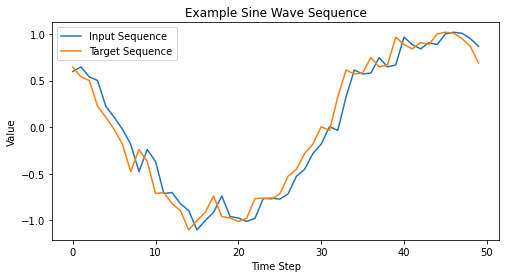

In [2]:
# Generate synthetic data: a sine wave sequence
def generate_sine_wave(seq_length, num_samples):
    """
    Generate a dataset of sine waves with added noise.
    Returns a tuple (data, targets) where each sample is of length seq_length.
    """
    X = []
    Y = []
    for _ in range(num_samples):
        # Random phase shift
        phase = np.random.rand() * 2 * np.pi
        x = np.linspace(0, 2 * np.pi, seq_length + 1) + phase
        data = np.sin(x) + 0.1 * np.random.randn(seq_length + 1)
        X.append(data[:-1])  # Input sequence
        Y.append(data[1:])   # Target sequence is shifted by one time step
    
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y

# Parameters for the synthetic dataset
seq_length = 50
num_samples = 1000

X_data, Y_data = generate_sine_wave(seq_length, num_samples)

# Convert to PyTorch tensors and add a feature dimension
X_tensor = torch.tensor(X_data).unsqueeze(-1)  # shape: [num_samples, seq_length, 1]
Y_tensor = torch.tensor(Y_data).unsqueeze(-1)  # shape: [num_samples, seq_length, 1]

print(f"X_tensor shape: {X_tensor.shape}")
print(f"Y_tensor shape: {Y_tensor.shape}")

# Visualize one example
plt.figure(figsize=(8, 4))
plt.plot(X_data[0], label='Input Sequence')
plt.plot(Y_data[0], label='Target Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Example Sine Wave Sequence')
plt.legend()
plt.show()

### 2.1 Defining a Simple RNN Model

We define an RNN model that uses PyTorch's `nn.RNN` layer. The network takes a sequence as input and outputs a sequence prediction (one step ahead).

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x: [batch, seq_length, input_size]
        out, hidden = self.rnn(x)  # out: [batch, seq_length, hidden_size]
        # Apply linear layer to each time step
        out = self.fc(out)  
        return out

# Initialize the RNN model
hidden_size = 32
num_layers = 1
rnn_model = SimpleRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)

print(rnn_model)

SimpleRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### 2.2 Training the Simple RNN Model

We train the model to predict the next value in the sequence. We use MSE as the loss function and Adam as the optimizer.

In [4]:
# Split the data into training and validation sets
train_ratio = 0.8
num_train = int(num_samples * train_ratio)

train_X = X_tensor[:num_train]
train_Y = Y_tensor[:num_train]

val_X = X_tensor[num_train:]
val_Y = Y_tensor[num_train:]

# Define training parameters
num_epochs = 50
batch_size = 32
learning_rate = 0.01

train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

rnn_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [10/50], Loss: 0.0175
Epoch [20/50], Loss: 0.0154
Epoch [30/50], Loss: 0.0149
Epoch [40/50], Loss: 0.0144
Epoch [50/50], Loss: 0.0141


### 2.3 Evaluating the RNN Model

Now, let’s visualize the predictions on a few validation sequences.

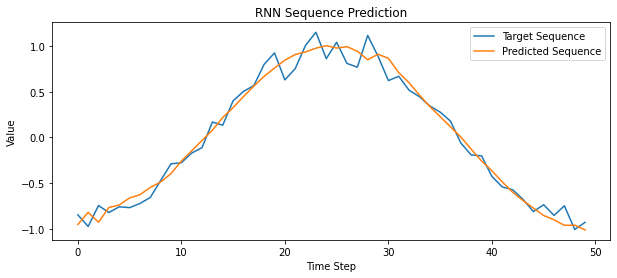

In [5]:
rnn_model.eval()
with torch.no_grad():
    sample_idx = 0
    input_seq = val_X[sample_idx:sample_idx+1]  # shape: [1, seq_length, 1]
    target_seq = val_Y[sample_idx].squeeze().numpy()
    predicted_seq = rnn_model(input_seq).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(target_seq, label='Target Sequence')
plt.plot(predicted_seq, label='Predicted Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('RNN Sequence Prediction')
plt.legend()
plt.show()

## 3. Long Short-Term Memory Networks (LSTMs)

LSTMs improve upon standard RNNs by introducing gating mechanisms that help the network learn long-term dependencies. In this section, we will implement an LSTM model on the same sine wave sequence prediction task.

We'll also briefly discuss advanced architectures like stacked and bidirectional LSTMs.

### 3.1 Defining an LSTM Model

We define an LSTM model using PyTorch's `nn.LSTM` layer. The model architecture is similar to the simple RNN model but uses LSTM cells.

In [6]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch, seq_length, input_size]
        out, (hn, cn) = self.lstm(x)  # out: [batch, seq_length, hidden_size]
        out = self.fc(out)
        return out

# Initialize the LSTM model
lstm_model = SimpleLSTM(input_size=1, hidden_size=32, num_layers=1, output_size=1)
print(lstm_model)

SimpleLSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### 3.2 Training the LSTM Model

We'll train the LSTM on the same task of sequence prediction using the sine wave dataset. The training procedure is similar to that for the RNN.

In [7]:
# Reset the optimizer and loss for the LSTM model
num_epochs_lstm = 50
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.01)
criterion_lstm = nn.MSELoss()

lstm_model.train()
for epoch in range(num_epochs_lstm):
    epoch_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion_lstm(outputs, batch_Y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 10 == 0:
        print(f"[LSTM] Epoch [{epoch+1}/{num_epochs_lstm}], Loss: {avg_loss:.4f}")

[LSTM] Epoch [10/50], Loss: 0.0148
[LSTM] Epoch [20/50], Loss: 0.0128
[LSTM] Epoch [30/50], Loss: 0.0125
[LSTM] Epoch [40/50], Loss: 0.0124
[LSTM] Epoch [50/50], Loss: 0.0124


### 3.3 Evaluating the LSTM Model

Let's visualize the predictions of the LSTM model on a sample from the validation set.

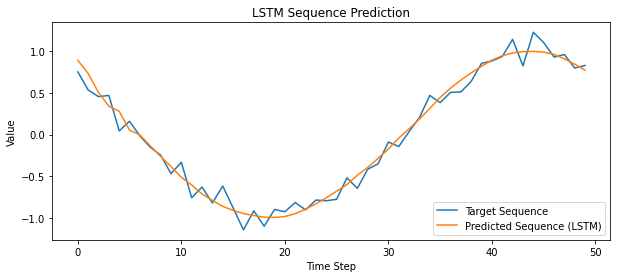

In [8]:
lstm_model.eval()
with torch.no_grad():
    sample_idx = 1
    input_seq = val_X[sample_idx:sample_idx+1]
    target_seq = val_Y[sample_idx].squeeze().numpy()
    predicted_seq = lstm_model(input_seq).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(target_seq, label='Target Sequence')
plt.plot(predicted_seq, label='Predicted Sequence (LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Sequence Prediction')
plt.legend()
plt.show()

## 4. Advanced LSTM Architectures

Beyond a single-layer LSTM, we can explore stacked (multi-layer) LSTMs and bidirectional LSTMs. These architectures can help capture more complex temporal patterns in data.

Below is a brief example of a stacked LSTM model.

In [9]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1, bidirectional=False):
        super(StackedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=bidirectional)
        
        # If bidirectional, the feature dimension is doubled
        fc_in_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_in_dim, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# Example: Create a stacked bidirectional LSTM
stacked_lstm_model = StackedLSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1, bidirectional=True)
print(stacked_lstm_model)

StackedLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. Conclusion

In this tutorial we:

- Reviewed the theory behind RNNs and the motivation for LSTMs.
- Implemented a simple RNN model to perform sequence prediction on a synthetic sine wave dataset.
- Developed an LSTM model and compared its predictions to the RNN model.
- Explored advanced LSTM architectures such as stacked and bidirectional LSTMs.

This notebook serves as a foundation for further exploration into sequential modeling tasks using PyTorch. Feel free to experiment with different architectures, hyperparameters, and datasets to deepen your understanding of recurrent neural networks and LSTMs.